In [1]:
from skimage import io, color, measure, draw, img_as_bool
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import cv2
import math
from scipy.optimize import curve_fit
from scipy.stats import linregress
from scipy.interpolate import splrep, sproot, splev
import matplotlib.gridspec as gridspec

In [2]:
def gauss_fit_pcov(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return pcov

In [3]:
def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))
def gauss_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return popt

In [4]:
def fwhm(x, y, k=3):
    """
    Determine full-with-half-maximum of a peaked set of points, x and y.

    Assumes that there is only one peak present in the datasset.  The function
    uses a spline interpolation of order k.
    """

    half_max = np.max(y)/2.0
    s = splrep(x, y - half_max, k=k)
    roots = sproot(s)

    if len(roots) > 2:
        raise MultiplePeaks("The dataset appears to have multiple peaks, and "
                "thus the FWHM can't be determined.")
    elif len(roots) < 2:
        raise NoPeaksFound("No proper peaks were found in the data set; likely "
                "the dataset is flat (e.g. all zeros).")
    else:
        return abs(roots[1] - roots[0])

In [5]:
def ellipse_fit(array,min_t,max_t):
    
    #paint a white color depend on level of light
    thresh = cv2.threshold(array,254 , 255, cv2.THRESH_BINARY)[1] 
    
    # find largest contour
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    big_contour = max(contours, key=cv2.contourArea)

    # fit contour to ellipse and get ellipse center, minor and major diameters and angle in degree 
    ellipse = cv2.fitEllipse(big_contour)
    (xc,yc),(major,minor),angle = ellipse

    # draw ellipse
    result = array.copy()
    cv2.ellipse(result, ellipse, (255, 0, 0), 3)

    # draw circle at center
    xc, yc = ellipse[0]
    cv2.circle(result, (int(xc),int(yc)), 10, (255, 255, 255), -1)

    # compute major radius
    if angle > 90:
        angle = angle - 90
    else:
        angle = angle + 90
        
    #output became a major, angle and the threshold of ellipse
    return major, angle 

In [6]:
# read input
img = cv2.imread('Picture/MOT_MODI_PIC.png')

# # convert to gray
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [7]:
vent_major , vent_angle = ellipse_fit(gray,254,255)
diameter_m = 34.6964*(10**-3)
scale_factor = diameter_m / vent_major
#unit pixel per meter
print(scale_factor)

2.535111137749588e-05


In [8]:
im_cal = cv2.imread('Picture/MOT_MODI_PIC.png')

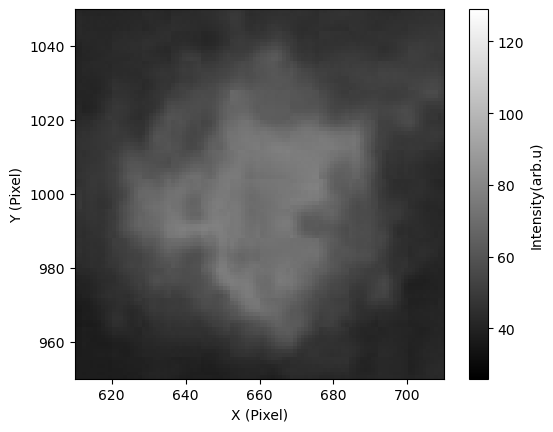

In [10]:
MOT_CUT = im_cal[610:710,950:1050]
plt.imshow(MOT_CUT,cmap='gray',extent = (610,710,950,1050))
plt.colorbar(label = 'Intensity(arb.u)')
plt.xlabel('X (Pixel)')
plt.ylabel('Y (Pixel)')
# plt.title('Selection area of cloud picture')
plt.savefig('Selection area of cloud picture in pixel.png')

In [12]:
pic_shape = np.shape(MOT_CUT)
print(pic_shape)

(100, 100, 3)


In [13]:
MOT_SUM = np.empty(pic_shape[1])
for i in range(pic_shape[1]):
    sum_y = np.sum(MOT_CUT[:,i])
    MOT_SUM[i] = sum_y
MOT_SUM = (MOT_SUM-np.min(MOT_SUM))/(np.max(MOT_SUM-np.min(MOT_SUM)))
MOT_FIT_CONST = gauss_fit(range(100), MOT_SUM)
MOT_FIT_pcov = np.abs(gauss_fit_pcov(range(100), MOT_SUM))
MOT_SUM_FIT = gauss(range(100), *MOT_FIT_CONST)

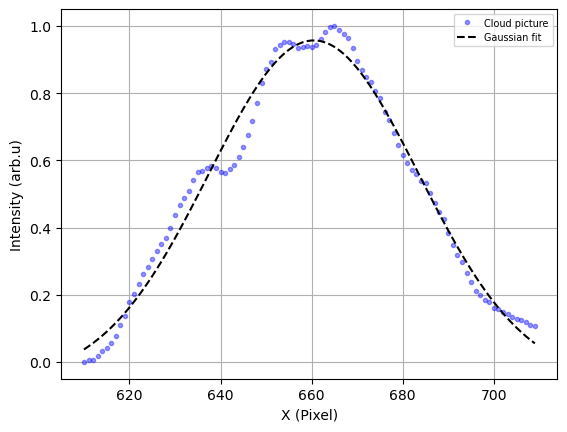

In [14]:
plt.plot(np.arange(610,710),MOT_SUM,'.',label = 'Cloud picture',alpha =0.4,color = 'blue')
plt.plot(np.arange(610,710),MOT_SUM_FIT,'--k',label = 'Gaussian fit')
# plt.title('Summation along 1-axis')
plt.xlabel('X (Pixel)')
plt.ylabel('Intensity (arb.u)')
plt.legend(loc = 'upper right',fontsize= 'x-small')
plt.grid()
plt.savefig('Summation along 1-axis in pixel.png')

In [23]:
FWHM = fwhm(range(100), MOT_SUM_FIT, k=3)
beam_width = 2*FWHM/(np.sqrt(2*np.log(2)))

In [26]:
sigma_mot_fit = MOT_FIT_CONST[3]
sigma_err = np.sqrt(np.diag(MOT_FIT_pcov))[3] * scale_factor
sigma_mot = sigma_mot_fit * scale_factor
MOT_SIZE = beam_width * scale_factor

In [28]:
print(MOT_SIZE , sigma_mot*1000000 , scale_factor, sigma_err*1000000)

0.0022491640470273227 585.3782630731235 2.535111137749588e-05 18.430426677420684


In [ ]:
plt.plot(np.arange(-50,50)*scale_factor,MOT_SUM,'.',label = 'Cloud picture',alpha =0.4,color = 'blue')
plt.plot(np.arange(-50,50)*scale_factor,MOT_SUM_FIT,'--k',label = 'Gaussian fit')
plt.title('Summation along 1-axis')
plt.xlabel('Position (m)')
plt.ylabel('Intensity (arb.u)')
plt.legend(loc = 'upper right',fontsize= 'x-small')
plt.grid()
plt.savefig('Summation along 1-axis in meters.png')